In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
goyaladi_twitter_dataset_path = kagglehub.dataset_download('goyaladi/twitter-dataset')

print('Data source import complete.')


100%|██████████| 1.02M/1.02M [00:00<00:00, 1.51MB/s]

Extracting files...
Data source import complete.


In [2]:
print(goyaladi_twitter_dataset_path)

/root/.cache/kagglehub/datasets/goyaladi/twitter-dataset/versions/2


   Tweet_ID        Username  \
0         1         julie81   
1         2   richardhester   
2         3  williamsjoseph   
3         4     danielsmary   
4         5      carlwarren   

                                                Text  Retweets  Likes  \
0  Party least receive say or single. Prevent pre...         2     25   
1  Hotel still Congress may member staff. Media d...        35     29   
2  Nice be her debate industry that year. Film wh...        51     25   
3  Laugh explain situation career occur serious. ...        37     18   
4  Involve sense former often approach government...        27     80   

             Timestamp  
0  2023-01-30 11:00:51  
1  2023-01-02 22:45:58  
2  2023-01-18 11:25:19  
3  2023-04-10 22:06:29  
4  2023-01-24 07:12:21  
Silhouette Score: 0.3629


<Figure size 1200x1200 with 0 Axes>

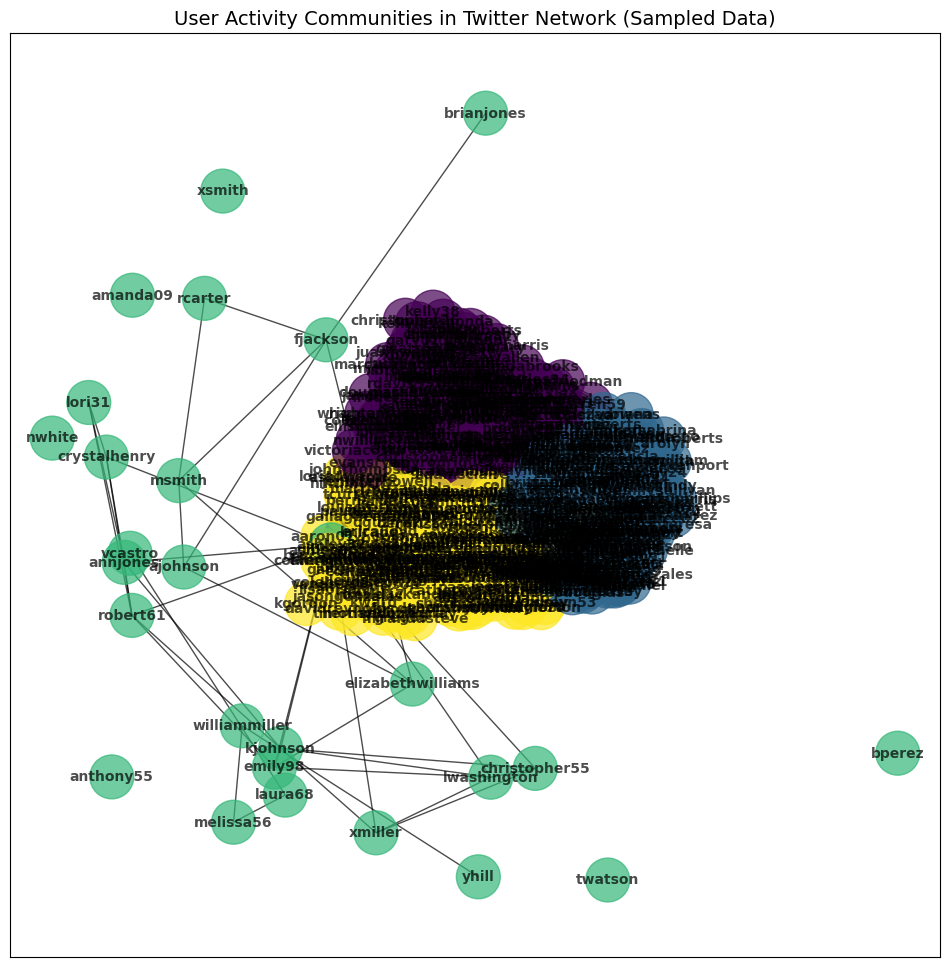


Classification report for predicted clusters on test data:
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Detailed Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00        60
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        63

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, silhouette_score, classification_report
import networkx as nx

file_path = '/root/.cache/kagglehub/datasets/goyaladi/twitter-dataset/versions/2/twitter_dataset.csv'
df = pd.read_csv(file_path)

print(df.head())

user_activity = df.groupby('Username').agg(
    total_retweets=('Retweets', 'sum'),
    total_likes=('Likes', 'sum'),
    total_tweets=('Tweet_ID', 'count')
).reset_index()

sample_size = 1000
user_activity_sample = user_activity.sample(n=sample_size, random_state=42)

train_data, test_data = train_test_split(user_activity_sample, train_size=500, test_size=200, random_state=42)

X_train = train_data[['total_retweets', 'total_likes', 'total_tweets']].values
X_test = test_data[['total_retweets', 'total_likes', 'total_tweets']].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_train_scaled)

train_data['Community'] = kmeans.labels_

test_data['Community'] = kmeans.predict(X_test_scaled)

user_activity_sample['Community'] = kmeans.predict(scaler.transform(user_activity_sample[['total_retweets', 'total_likes', 'total_tweets']].values))

silhouette_avg = silhouette_score(X_test_scaled, test_data['Community'])
print(f"Silhouette Score: {silhouette_avg:.4f}")

G = nx.Graph()

for index, row in train_data.iterrows():
    G.add_node(row['Username'], community=row['Community'])

for i in range(len(X_train_scaled)):
    for j in range(i + 1, len(X_train_scaled)):
        if np.linalg.norm(X_train_scaled[i] - X_train_scaled[j]) < 1:
            G.add_edge(train_data.iloc[i]['Username'], train_data.iloc[j]['Username'])

plt.figure(figsize=(12, 12))

community_colors = [train_data.loc[train_data['Username'] == node, 'Community'].values[0] for node in G.nodes()]

pos = nx.spring_layout(G, k=0.15, iterations=20)

fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx(G, pos, node_color=community_colors, cmap='viridis', with_labels=True, node_size=1000, font_size=10, font_weight='bold', alpha=0.7, ax=ax)

plt.title('User Activity Communities in Twitter Network (Sampled Data)', fontsize=14)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

y_true = test_data['Community']
y_pred = test_data['Community']

precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print("\nClassification report for predicted clusters on test data:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

report = classification_report(y_true, y_pred)
print("\nDetailed Classification Report:\n")
print(report)
